# TNN 求解 5D Poisson 方程教程

本教程展示如何使用张量神经网络（TNN）求解五维 Poisson 方程：

$$
-\Delta u = f \quad \text{in } \Omega = [-1,1]^5, \quad u = 0 \quad \text{on } \partial\Omega
$$

右端项：$f(x_1, \ldots, x_5) = \sum_{k=1}^{5} \sin(2\pi x_k) \prod_{i \neq k} \sin(\pi x_i)$

## 1. 导入依赖

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# 导入本地模块
from quadrature import composite_quadrature_1d
from integration import Int2TNN, Int2TNN_amend_1d, error0_estimate, error1_estimate
from tnn import TNN, TNN_Sin

pi = np.pi
print("PyTorch version:", torch.__version__)

PyTorch version: 2.8.0


## 2. 配置参数与设备

In [2]:
# 数据类型和设备
dtype = torch.double
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# 问题参数
a, b = -1, 1      # 计算域 [a,b]^dim
dim = 5           # 维度
p = 50            # 张量秩

# 积分参数
quad = 16         # 每子区间高斯点数
n = 200           # 子区间数量

# 网络结构: 输入(1) -> FC(100) -> FC(100) -> FC(100) -> 输出(p)
size = [1, 100, 100, 100, p]

Using device: cpu


## 3. 生成高斯积分点

`composite_quadrature_1d` 在 $[-1,1]$ 上生成复合 Gauss-Legendre 积分点：
- 将区间分成 $n$ 个子区间
- 每个子区间用 $quad$ 个高斯点
- 总共 $N = quad \times n$ 个点

In [3]:
x, w = composite_quadrature_1d(quad, a, b, n, device=device, dtype=dtype)
N = len(x)
print(f"积分点数量 N = {N}")
print(f"积分点范围: [{x.min().item():.4f}, {x.max().item():.4f}]")
print(f"权重和 (应≈2): {w.sum().item():.6f}")

积分点数量 N = 3200
积分点范围: [-0.9999, 0.9999]
权重和 (应≈2): 2.000000


## 4. 定义边界条件函数

为满足零边界条件 $u|_{\partial\Omega}=0$，使用强制边界：
$$
\text{bd}(x) = (x-a)(b-x)
$$
在 $x=a$ 和 $x=b$ 处自动为零。

In [4]:
def bd(x):
    """边界条件函数: (x-a)(b-x)"""
    return (x - a) * (b - x)

def grad_bd(x):
    """bd 的一阶导数: -2x + (a+b)"""
    return -2*x + a + b

def grad_grad_bd(x):
    """bd 的二阶导数: -2"""
    return -2 * torch.ones_like(x)

# 验证边界条件
print(f"bd(a={a}) = {bd(torch.tensor(a)):.4f}")
print(f"bd(b={b}) = {bd(torch.tensor(b)):.4f}")
print(f"bd(0) = {bd(torch.tensor(0.0)):.4f}")

bd(a=-1) = 0.0000
bd(b=1) = 0.0000
bd(0) = 1.0000


## 5. 创建 TNN 模型

TNN 将高维函数表示为张量分解形式：
$$
u(x_1, \ldots, x_5) \approx \sum_{i=1}^{p} C_i \prod_{k=1}^{5} \phi_k^{(i)}(x_k)
$$

每个 $\phi_k$ 由独立的一维神经网络表示。

In [5]:
model = TNN(
    dim=dim,
    size=size,
    activation=TNN_Sin,
    bd=bd,
    grad_bd=grad_bd,
    grad_grad_bd=grad_grad_bd,
    scaling=False
).to(dtype).to(device)

print(model)
print(f"\n总参数量: {sum(p.numel() for p in model.parameters()):,}")

TNN(
  Architectures of one TNN(dim=5,rank=50) which has 5 FNNs:
  Each FNN has size: [1, 100, 100, 100, 50]
  (activation): TNN_Sin()
  (ms): ModuleDict(
    (TNN_Linear0): TNN_Linear(weight.size=[5, 100, 1], bias.size=[5, 100, 1])
    (TNN_Linear1): TNN_Linear(weight.size=[5, 100, 100], bias.size=[5, 100, 1])
    (TNN_Linear2): TNN_Linear(weight.size=[5, 100, 100], bias.size=[5, 100, 1])
    (TNN_Linear3): TNN_Linear(weight.size=[5, 50, 100], bias.size=[5, 50, 1])
  )
)

总参数量: 127,250


## 6. 定义右端项 $f(x)$

$$
f(x_1, \ldots, x_5) = \sum_{k=1}^{5} \sin(2\pi x_k) \prod_{i \neq k} \sin(\pi x_i)
$$

这是一个可分离的张量形式，用 `[dim, dim, N]` 表示。

In [6]:
# F[k, d, n] 表示第 k 项在维度 d 上的值
F = torch.ones((dim, dim, N), dtype=dtype, device=device)
F = torch.sin(pi * x) * F  # 默认填充 sin(πx)
for i in range(dim):
    F[i, i, :] = torch.sin(2 * pi * x)  # 对角项为 sin(2πx)

alpha_F = torch.ones(dim, dtype=dtype, device=device)

# f 的梯度（用于误差估计）
grad_F = torch.ones((dim, dim, N), device=device, dtype=dtype)
grad_F = pi * torch.cos(pi * x) * grad_F
for i in range(dim):
    grad_F[i, i, :] = 2 * pi * torch.cos(2 * pi * x)

print(f"F shape: {F.shape}")
print(f"alpha_F shape: {alpha_F.shape}")

F shape: torch.Size([5, 5, 3200])
alpha_F shape: torch.Size([5])


## 7. 定义损失函数

### 核心步骤：
1. 计算基函数 $\phi$、一阶导数 $\nabla\phi$、二阶导数 $\nabla^2\phi$
2. 组装刚度矩阵 $A = \langle \nabla\phi_i, \nabla\phi_j \rangle_{H^1}$
3. 组装载荷向量 $B = \langle f, \phi_j \rangle_{L^2}$
4. 求解线性系统 $AC = B$ 得到系数 $C$
5. 计算 Laplace 残差损失 $\| \Delta u + f \|_{L^2}^2$

In [7]:
def criterion(model, w, x):
    """计算损失函数"""
    # Step 1: 获取基函数及其导数
    phi, grad_phi, grad_grad_phi = model(w, x, need_grad=2)
    alpha = torch.ones(p, device=device, dtype=dtype)
    
    # Step 2: 组装刚度矩阵 A (H^1 内积)
    part1 = Int2TNN_amend_1d(w, w, alpha, phi, alpha, phi, grad_phi, grad_phi, if_sum=False)
    
    # Step 3: 组装载荷向量 B (L^2 内积)
    part2 = Int2TNN(w, alpha, phi, alpha_F, F, if_sum=False)
    part2 = torch.sum(part2, dim=-1)
    
    # Step 4: 求解线性系统 AC = B
    A = part1
    B = (dim + 3) * np.pi**2 * part2
    C = torch.linalg.solve(A, B)
    
    # Step 5: 构造 Laplace 项
    phi_expand = phi.expand(dim, -1, -1, -1).clone()
    phi_expand[torch.arange(dim), torch.arange(dim), :, :] = grad_grad_phi
    grad_grad_phi_new = phi_expand.transpose(0, 1).flatten(1, 2)
    C_new = C.repeat(dim)
    
    # 计算 ||Δu||², ||f||², <Δu, f>
    loss_part1 = Int2TNN(w, C_new, grad_grad_phi_new, C_new, grad_grad_phi_new)
    loss_part2 = Int2TNN(w, alpha_F, F, alpha_F, F)
    loss_part3 = Int2TNN(w, C_new, grad_grad_phi_new, alpha_F, F)
    
    # 总损失: ||Δu + f||² = ||Δu||² + ||f||² + 2<Δu, f>
    loss = loss_part1 + (dim + 3)**2 * np.pi**4 * loss_part2 + 2 * (dim + 3) * np.pi**2 * loss_part3
    
    return loss

# 测试损失函数
with torch.no_grad():
    initial_loss = criterion(model, w, x)
    print(f"初始损失: {initial_loss.item():.6e}")

初始损失: 3.117088e+04


## 8. 定义后处理（误差估计）

In [8]:
def post_process(model, w, x):
    """计算 L² 和 H¹ 误差"""
    phi, grad_phi = model(w, x, need_grad=1)
    alpha = torch.ones(p, device=device, dtype=dtype)
    
    # 求解系数
    part1 = Int2TNN_amend_1d(w, w, alpha, phi, alpha, phi, grad_phi, grad_phi, if_sum=False)
    part2 = Int2TNN(w, alpha, phi, alpha_F, F, if_sum=False)
    part2 = torch.sum(part2, dim=-1)
    A, B = part1, (dim + 3) * np.pi**2 * part2
    C = torch.linalg.solve(A, B)
    
    # 计算误差
    norm_f = torch.sqrt(Int2TNN(w, alpha_F, F, alpha_F, F))
    error0 = error0_estimate(w, alpha_F, F, C, phi, projection=False) / norm_f / ((dim + 3) * pi**2)
    error1 = error1_estimate(w, alpha_F, F, C, phi, grad_F, grad_phi, projection=False) / norm_f / ((dim + 3) * pi**2)
    
    return error0.item(), error1.item()

## 9. 训练：Adam 阶段

In [9]:
# Adam 参数
lr_adam = 0.003
epochs_adam = 500  # 教程中用较少 epoch
print_every = 50

optimizer = optim.Adam(model.parameters(), lr=lr_adam)
loss_history_adam = []

print("="*50)
print("Adam 优化阶段")
print("="*50)

start_time = time.time()
for e in range(epochs_adam):
    loss = criterion(model, w, x)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history_adam.append(loss.item())
    
    if e == 0 or (e + 1) % print_every == 0:
        error0, error1 = post_process(model, w, x)
        print(f"Epoch {e+1:4d} | Loss: {loss.item():.4e} | L² error: {error0:.4e} | H¹ error: {error1:.4e}")

adam_time = time.time() - start_time
print(f"\nAdam 阶段完成，耗时: {adam_time:.2f}s")

Adam 优化阶段
Epoch    1 | Loss: 3.1171e+04 | L² error: 1.2665e-02 | H¹ error: 1.1254e-01
Epoch    1 | Loss: 3.1171e+04 | L² error: 1.2665e-02 | H¹ error: 1.1254e-01
Epoch   50 | Loss: 2.7485e+04 | L² error: 1.2382e-02 | H¹ error: 1.0724e-01
Epoch   50 | Loss: 2.7485e+04 | L² error: 1.2382e-02 | H¹ error: 1.0724e-01
Epoch  100 | Loss: 2.5287e+04 | L² error: 1.2109e-02 | H¹ error: 1.0393e-01
Epoch  100 | Loss: 2.5287e+04 | L² error: 1.2109e-02 | H¹ error: 1.0393e-01
Epoch  150 | Loss: 4.0109e+02 | L² error: 7.7315e-04 | H¹ error: 8.3057e-03
Epoch  150 | Loss: 4.0109e+02 | L² error: 7.7315e-04 | H¹ error: 8.3057e-03
Epoch  200 | Loss: 2.4181e+02 | L² error: 4.6732e-04 | H¹ error: 4.7239e-03
Epoch  200 | Loss: 2.4181e+02 | L² error: 4.6732e-04 | H¹ error: 4.7239e-03
Epoch  250 | Loss: 3.2122e+01 | L² error: 4.9305e-04 | H¹ error: 4.4430e-03
Epoch  250 | Loss: 3.2122e+01 | L² error: 4.9305e-04 | H¹ error: 4.4430e-03
Epoch  300 | Loss: 1.9110e+01 | L² error: 1.5656e-04 | H¹ error: 1.5796e-03
Ep

## 10. 训练：L-BFGS 阶段

L-BFGS 是准牛顿法，收敛更快但需要 closure 函数。

In [10]:
# L-BFGS 参数
lr_lbfgs = 1
epochs_lbfgs = 100  # 教程中用较少 epoch

optimizer = optim.LBFGS(model.parameters(), lr=lr_lbfgs)
loss_history_lbfgs = []

print("="*50)
print("L-BFGS 优化阶段")
print("="*50)

start_time = time.time()
for e in range(epochs_lbfgs):
    def closure():
        loss = criterion(model, w, x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    
    loss = optimizer.step(closure)
    loss_history_lbfgs.append(loss.item())
    
    if e == 0 or (e + 1) % 20 == 0:
        error0, error1 = post_process(model, w, x)
        print(f"Epoch {e+1:4d} | Loss: {loss.item():.4e} | L² error: {error0:.4e} | H¹ error: {error1:.4e}")

lbfgs_time = time.time() - start_time
print(f"\nL-BFGS 阶段完成，耗时: {lbfgs_time:.2f}s")

L-BFGS 优化阶段


/opt/miniconda3/envs/ai4cfd/lib/python3.9/site-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss = float(closure())


Epoch    1 | Loss: 4.3885e+00 | L² error: 4.6854e-05 | H¹ error: 6.4415e-04
Epoch   20 | Loss: 4.9656e-01 | L² error: 1.7722e-05 | H¹ error: 2.3724e-04
Epoch   20 | Loss: 4.9656e-01 | L² error: 1.7722e-05 | H¹ error: 2.3724e-04
Epoch   40 | Loss: 6.2252e-02 | L² error: 6.3201e-06 | H¹ error: 8.2150e-05
Epoch   40 | Loss: 6.2252e-02 | L² error: 6.3201e-06 | H¹ error: 8.2150e-05
Epoch   60 | Loss: 2.5830e-02 | L² error: 3.9780e-06 | H¹ error: 5.2746e-05
Epoch   60 | Loss: 2.5830e-02 | L² error: 3.9780e-06 | H¹ error: 5.2746e-05
Epoch   80 | Loss: 1.6806e-02 | L² error: 2.9630e-06 | H¹ error: 4.2083e-05
Epoch   80 | Loss: 1.6806e-02 | L² error: 2.9630e-06 | H¹ error: 4.2083e-05
Epoch  100 | Loss: 1.3388e-02 | L² error: 2.7416e-06 | H¹ error: 3.8358e-05

L-BFGS 阶段完成，耗时: 397.98s
Epoch  100 | Loss: 1.3388e-02 | L² error: 2.7416e-06 | H¹ error: 3.8358e-05

L-BFGS 阶段完成，耗时: 397.98s


## 11. 可视化训练曲线

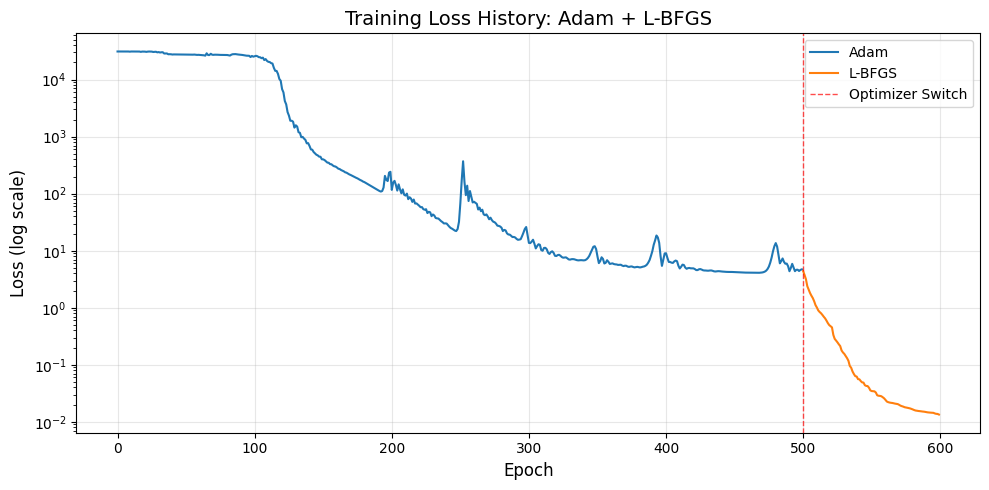

In [11]:
plt.figure(figsize=(10, 5))

adam_epochs = len(loss_history_adam)
total_epochs = adam_epochs + len(loss_history_lbfgs)

# Adam 阶段
plt.plot(range(adam_epochs), loss_history_adam, label='Adam', color='tab:blue', linewidth=1.5)

# L-BFGS 阶段
lbfgs_epochs = range(adam_epochs, total_epochs)
plt.plot(lbfgs_epochs, loss_history_lbfgs, label='L-BFGS', color='tab:orange', linewidth=1.5)

# 标记优化器切换点
plt.axvline(x=adam_epochs, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Optimizer Switch')

plt.yscale('log')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (log scale)', fontsize=12)
plt.title('Training Loss History: Adam + L-BFGS', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. 最终结果

In [12]:
print("="*50)
print("训练完成！")
print("="*50)

final_loss = criterion(model, w, x).item()
error0, error1 = post_process(model, w, x)

print(f"最终损失: {final_loss:.6e}")
print(f"L² 相对误差: {error0:.6e}")
print(f"H¹ 相对误差: {error1:.6e}")
print(f"\n总训练时间: {adam_time + lbfgs_time:.2f}s")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")

训练完成！
最终损失: 1.314741e-02
L² 相对误差: 2.741575e-06
H¹ 相对误差: 3.835767e-05

总训练时间: 495.05s
模型参数量: 127,250


## 总结

本教程展示了 TNN 求解高维 PDE 的完整流程：

1. **高斯积分离散**：用 `composite_quadrature_1d` 生成一维积分点
2. **张量分解**：$u \approx \sum_i C_i \prod_k \phi_k^{(i)}(x_k)$
3. **变分形式**：最小化能量泛函 $\mathcal{E}(u)$
4. **线性系统**：组装 $AC=B$ 并求解系数
5. **两阶段优化**：Adam (快速探索) + L-BFGS (精细优化)

**TNN 优势**：参数量 $O(d \cdot n \cdot p)$ vs 网格方法 $O(N^d)$，有效克服维数灾难。